# Creating an example of a circuit cost function

In [2]:
from qiskit.circuit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from random import randrange
from numpy import pi
from project.unified_noise_model.Unified_Noise_Model import Unified_Noise_Model

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['rz']
  All-qubits errors: ['rz']


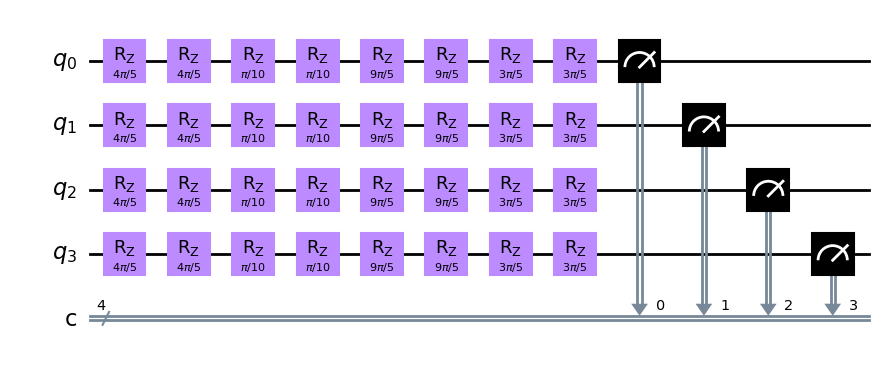

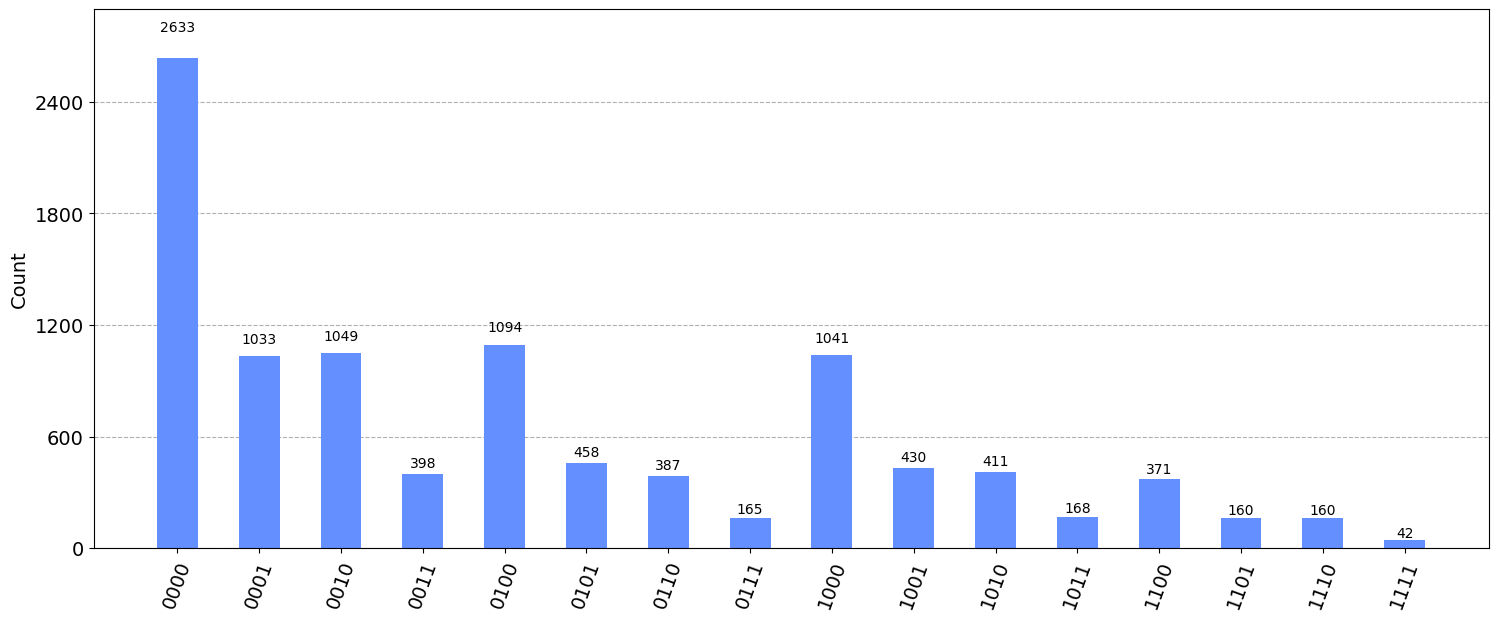

qubit  0  average: 0.2783 

qubit  1  average: 0.2837 

qubit  2  average: 0.278 

qubit  3  average: 0.2854 

cost: 1.1254 



In [5]:

def cost_func(num_qubits,num_iterations,noise_model):
    qc = QuantumCircuit(num_qubits,num_qubits)
    shots=10000
    
    #Add random phi cz gates
    for itr in range(num_iterations):
        random_phi = randrange(0,20,step=1)
        random_phi = random_phi / 10
        for q in range(num_qubits):
            qc.rz(random_phi * pi,q)
            qc.rz(random_phi * pi,q)
            
    qc.measure(range(num_qubits),range(num_qubits))
    display(qc.draw('mpl'))
    
    #Run the circuit 10000 times and store the results
    simulator = AerSimulator(noise_model=noise_model)
    result = simulator.run(qc,shots=shots).result()
    counts = result.get_counts(0)
    display(plot_histogram(counts,figsize=[18,7]))

    #Calculate the average for result of each qubit, and finally sum each of the averages to get the COST.
    cost = 0
    for qubit in range(num_qubits):
        qubit_average = 0
        for string in counts.keys():
            current_qubit_in_current_string = string[qubit]
            if current_qubit_in_current_string == '1':
                qubit_average += counts[string]
        qubit_average = qubit_average / shots
        print('qubit ',qubit,' average:',qubit_average,'\n')
        cost += qubit_average
    return cost
                
unm = Unified_Noise_Model()
#noise model with 0.2 of depolarization prob
unm.add_depolarizing_channel(0.1,['rz'],[])
print(unm.noise_model)

#cost function with 5 qubits and 4 iterations
cost = cost_func(4,4,unm.noise_model) 
print('cost:',cost,'\n')
